# Practica # 1 - Tensorflow - Gradient Descent y Tensorboard

## Datos de Proyecto - Carga

Se cargará el Dataset del Proyecto del Curso **"Ciencia de Datos en Python"**; para referencia se coloca el listado de variables que contiene el Dataset:
* **SalePrice:** The property's sale price in dollars. This is the target variable that you're trying to predict.
* **OverallQual:** Overall material and finish quality, rates the overall material and finish of the house
       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
* **1stFlrSF:** First Floor square feet
* **TotRmsAbvGrd:** Total rooms above grade (does not include bathrooms)
* **YearBuilt:** Original construction date
* **LotFrontage:** Linear feet of street connected to property

In [9]:
#Importamos Libreria de Numpy para cargar los datos
import numpy as np

House_Data = np.load('proyecto_data/proyecto_training_data.npy')

##Verificamos que haya cargado la información, y que tenga la forma requerida
print('Rango Tensor:',House_Data.ndim)
print('Forma Tensor:',House_Data.shape)
print('Vemos Primer Registro:',House_Data[0])

Rango Tensor: 2
Forma Tensor: (1460, 6)
Vemos Primer Registro: [2.085e+05 7.000e+00 8.560e+02 8.000e+00 2.003e+03 6.500e+01]


## Datos de Entrenamiento

Consideremos lo siguiente:
* La variable Dependiente seguirá siendo **"SalesPrice"**
* La variable Independiente (FEATURE) será **"OverallQual"** que demostró una mayor correlación para el proyecto pasado.
* Tomaremos todo el Dataset para Entrenamiento, esta vez no separaremos el Dataset.

In [10]:
#Por Facilidad se manejaran tensores quitando los datos que no utilizaremos
##OverallQual - Variable Independiente (FEATURE)
x_train = House_Data[:,1]

##Valor de Ventas Real -  Variable Dependiente
##Al Igual que el Proyecto por facilidad dividiremos por 1000 el precio de las casas
y_real = House_Data[:,0]/1000

## TensorFlow - Definición Modelo

Importamos las librerias y ejecutamos los comandos requeridos para utilizar tensorflow.

In [11]:
import tensorflow as tf

print(tf.__version__)

2.1.0


In [12]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


Creamos la Clase que almacenará la definición del Modelo

In [13]:
'''Clase que Definirá el Modelo a Entrenar'''
class Modelo:
    
    '''Metodo que define lo que se ejecuta al Instanciar la Clase'''
    def __init__(self):
        
        #Limpiamos cualquier variable o operación en el grafo 
        tf.reset_default_graph()
        
        #Variables que "Entrenará" el Modelo
        self.m = tf.get_variable("pendiente",dtype=tf.float32,shape=[],initializer=tf.zeros_initializer())
        self.b = tf.get_variable("intercepto",dtype=tf.float32,shape=[],initializer=tf.zeros_initializer())

        ##Definimos los Tensores para la Inicialización de Variables
        with tf.name_scope("Inicializacion"):
            init_global = tf.global_variables_initializer()
            init_local = tf.local_variables_initializer()
            self.init = tf.group(init_global,init_local)
    
    '''Metodo que define el Modelo de Predicción'''    
    def __call__(self,x):
        ##Definimos el Modelo de Predicción
        with tf.name_scope("Modelo"):
            #lo almacenamos en la propiedad de la clase self.y_hat para que pueda reutilizarse en los otros metodos
            #y no llamarlos varias veces - creando multiples instancias del modelo en tensorboard
            self.y_hat = tf.add(tf.multiply(self.m,x),self.b,name="Prediccion_Modelo")
        return self.y_hat
    
    '''Metodo que define la Función de Error del Modelo''' 
    def error_function(self,y,y_hat):
        ##Definimos la función de Error
        with tf.name_scope("Error"):
            #lo almacenamos en la propiedad de la clase self.error para que pueda reutilizarse en los otros metodos
            #y no llamarlos varias veces - creando multiples instancias del modelo en tensorboard
            self.error = 1/2*tf.reduce_mean(tf.math.square(y - y_hat) )
        return self.error
    
    '''Metodo que define como se actualizan las variables que se entrenan en el Modelo''' 
    def actualizar(self,x,y,learning_rate):
        #Quitamos esto - Para no crear multiples tensores con el modelo de predicción
        #y_hat = self(x) 
    
        #Quitamos esto - Para no crear multiples tensores con el modelo de Error
        #error = self.error_function(y,self.y_hat)
        
        #Calculo de la Gradiente - Para variables de Pendiente e Intercepto
        with tf.name_scope("Calculo_Gradiente"):
            gradiente = tf.gradients(self.error,[self.m, self.b])
        
        #Actualización de Variables del Modelo - Definición Tensores
        with tf.name_scope("Act_Parametros_Modelo"):
            actualizacion_m = tf.assign(self.m, self.m - learning_rate*gradiente[0] )
            actualizacion_b = tf.assign(self.b, self.b - learning_rate*gradiente[1] )
            actualizacion_parametros = tf.group(actualizacion_m,actualizacion_b)

        return actualizacion_parametros
    
    '''Metodo que define el Scalar para Tensorboard'''
    def summary(self,x,y):
        #Quitamos esto - Para no crear multiples tensores con el modelo de predicción
        #self.y_hat = self(x)
        
        #Quitamos esto - Para no crear multiples tensores con el modelo de Error
        #error = self.error_function(y,self.y_hat)
        
        #Creamos el Tensor con la Información del Scalar
        MSE_summary = tf.summary.scalar(name='MSE_Function', tensor=self.error)
        return MSE_summary
        

Definimos la Función de Entrenamiento

In [14]:
import time

def Entrenamiento(learning_rate,epochs,imprimir_cada,x,y):
    #Instanciamos la Clase que define el Modelo
    modelo = Modelo()

    #string de configuración para almacenamiento del Grafo
    string_conf= time.strftime("%Y%m%d") + "_"+time.strftime("%H%M%S")+"_Batch_GradientDescent_Lr="+str(learning_rate)

    #Definimos los Placeholders que almacenarán los datos de Entrenamiento del Modelo
    tensor_x = tf.placeholder(tf.float32,[x.shape[0]],name="tensor_x")
    tensor_y = tf.placeholder(tf.float32,[x.shape[0]],name="tensor_y")

    #Llamamos a la función que define el modelo de Predicción
    prediccion = modelo(tensor_x)

    #Llamamos a la función que define la Función de Error (Costo)
    funcion_error = modelo.error_function(prediccion,tensor_y)

    #Llamamos a la función que define los tensores para actualizar las variables del Modelo
    actualizacion_parametros = modelo.actualizar(tensor_x,tensor_y,learning_rate)

    #llamamos a la función que define el Scalar a Reportar en Tensorboard
    MSE_summary = modelo.summary(tensor_x,tensor_y)

    #Iniciamos con una Sesión Monitoreada - Para el Entrenamiento del Modelo
    with tf.train.MonitoredSession() as session:

        # Inicialización de variables Globales y locales
        session.run(modelo.init)

        #Escritura del Grafo para Tensorboard
        writer = tf.summary.FileWriter('./graphs/'+string_conf, session.graph)

        #Creamos el Diccionario que le dará valor a los Placeholders
        feed_dict = {tensor_x:x, tensor_y:y}

        #Entrenamiento del Modelo
        for step in range(epochs):

            #Ejecutamos el Grafo - Actualización de Datos
            session.run(actualizacion_parametros,feed_dict=feed_dict)

            #Ejecutamos el Grafo - Predicción del Modelo
            predicciones = session.run(prediccion,feed_dict=feed_dict)

            #Ejecutamos el Grafo - Resultado de Variables Entrenadas
            pendiente_final,intercepto_final = session.run([modelo.m,modelo.b],feed_dict=feed_dict)

            #Ejecutamos el Grafo - Datos Escalar
            summary = session.run(MSE_summary,feed_dict=feed_dict)

            #Almacenamos datos de Scalar - Para Tensorboard
            writer.add_summary(summary, step)

            #Imprimimos resultados de Variables por entrenamiento - Cada N Entrenamientos
            if (step+1) % imprimir_cada == 0:
                print("Prueba {} - Parámetros finales: m={}  b={}".format(step+1,pendiente_final,intercepto_final))

        # Si queremos imprimir la función de Error - Despues del Entrenamiento 
        final_error = session.run(funcion_error,feed_dict=feed_dict)
        print("Error - Despues de Entrenamiento={}".format(final_error))

Probamos el Modelo solo para asegurar que no haya errores. Por el momento es con valores pequeños de prueba

In [16]:
#Usaremos el mismo Learning rate del Proyecto
learning_rate = 0.001

#Definimos cuantas iteraciones de Entrenamiento haremos
epochs=100

#Definimos cada cuanto vamos a imprimir
imprimir_cada = 50

#Ejecutamos la función de Entrenamiento para los parametros definidos
Entrenamiento(learning_rate,epochs,imprimir_cada,x_train,y_real)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Prueba 50 - Parámetros finales: m=25.88538360595703  b=3.795400619506836
Prueba 100 - Parámetros finales: m=29.268674850463867  b=4.078108310699463
Error - Despues de Entrenamiento=1431.6644287109375


## Tensorboard - Grafo

Vemos como quedo nuestro Grafo en Tensorboard, de acuerdo al modelo definido.

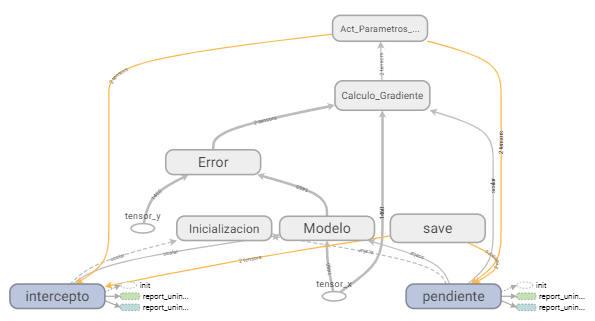

## Tensorboard - Scalar

El Error obtenido por la función MSE (Mean Squared Error) se puede visualizar en tensorbord de la siguiente manera:

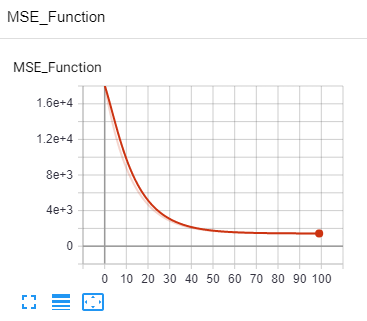